In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [3]:
pbp_py_run = pd.read_pickle("../datasets/filtered_nfl_run_multi_plays.pkl")

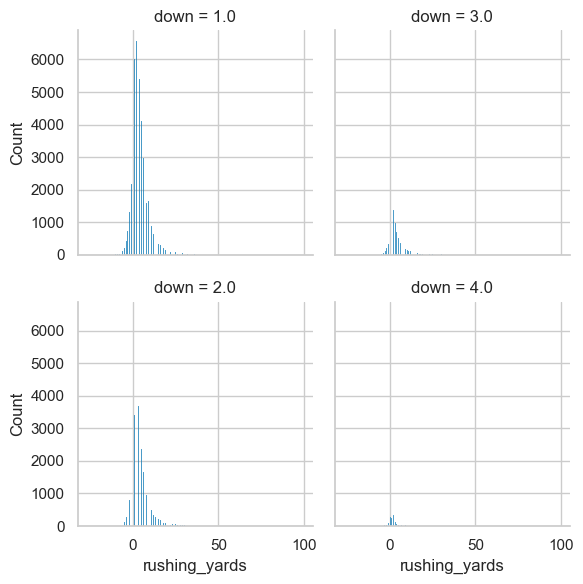

In [4]:
# Create histogram for down and rushing yards
sns.set_theme(style="whitegrid", palette="colorblind")
pbp_py_run.down = pbp_py_run.down.astype(str)
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.show()

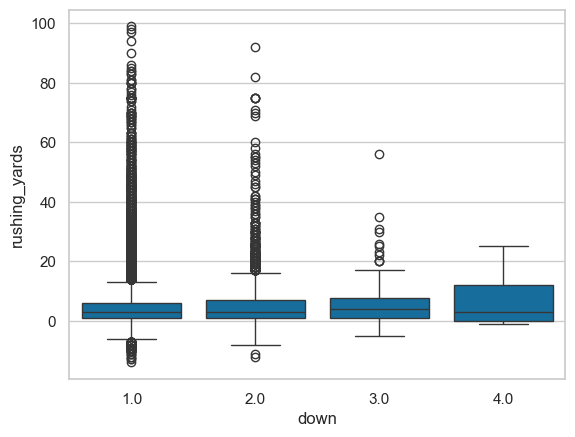

In [5]:
# Boxplot for plays with 10 yards to go
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"), x="down", y="rushing_yards")
plt.show()

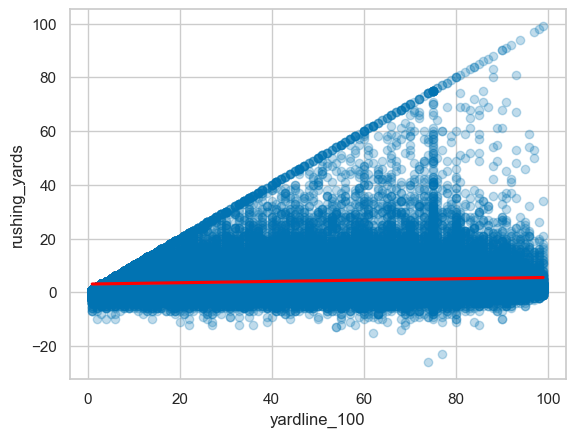

In [6]:
# Scatterplot for yardline_100 vs rushing yards
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"}
)
plt.show()

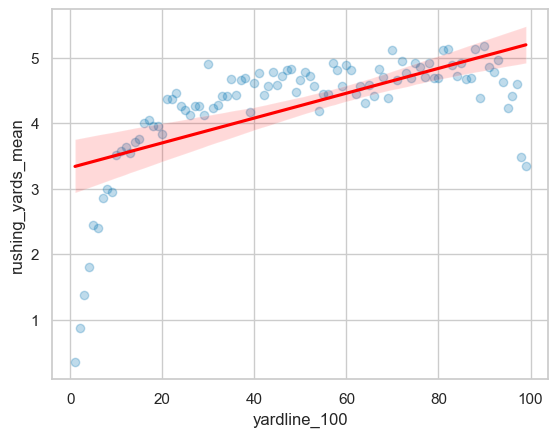

In [8]:
# Binned yardline_100 analysis
pbp_py_run_y100 = (
    pbp_py_run
    .groupby("yardline_100")
    .agg({"rushing_yards": ["mean"]})
)
pbp_py_run_y100.columns = list(map("_".join, pbp_py_run_y100.columns))
pbp_py_run_y100.reset_index(inplace=True)
sns.regplot(
    data=pbp_py_run_y100,
    x="yardline_100",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"}
)
plt.show()

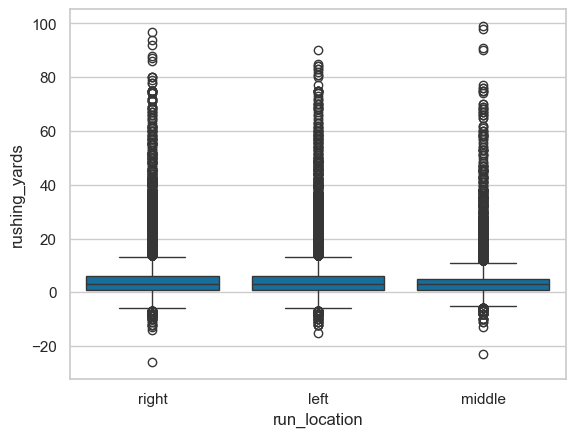

In [9]:
# Boxplot for run_location
sns.boxplot(data=pbp_py_run, x="run_location", y="rushing_yards")
plt.show()

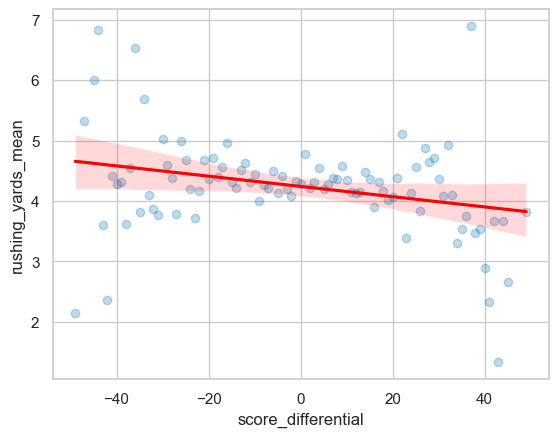

In [11]:
# Binned score_differential analysis
pbp_py_run_sd = (
    pbp_py_run
    .groupby("score_differential")
    .agg({"rushing_yards": ["mean"]})
)
pbp_py_run_sd.columns = list(map("_".join, pbp_py_run_sd.columns))
pbp_py_run_sd.reset_index(inplace=True)
sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"}
)
plt.show()

In [12]:
# Fit multiple linear regression model
pbp_py_run.down = pbp_py_run.down.astype(str)
expected_yards_py = smf.ols(
    data=pbp_py_run,
    formula="rushing_yards ~ 1 + down + ydstogo + down:ydstogo + yardline_100 + run_location + score_differential"
).fit()
pbp_py_run["ryoe"] = expected_yards_py.resid

# Model summary
print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          3.30e-313
Time:                        10:55:59   Log-Likelihood:            -2.9758e+05
No. Observations:               91425   AIC:                         5.952e+05
Df Residuals:                   91413   BIC:                         5.953e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [13]:
# Analyze RYOE
ryoe_py = (
    pbp_py_run
    .groupby(["season", "rusher_id", "rusher"])
    .agg({"ryoe": ["count", "sum", "mean"], "rushing_yards": ["mean"]})
)
ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)
ryoe_py = ryoe_py.rename(columns={
    "ryoe_count": "n",
    "ryoe_sum": "ryoe_total",
    "ryoe_mean": "ryoe_per",
    "rushing_yards_mean": "yards_per_carry"
}).query("n > 50")

# Display sorted results
print(ryoe_py.sort_values("ryoe_total", ascending=False))
print(ryoe_py.sort_values("ryoe_per", ascending=False))

      season   rusher_id      rusher    n  ryoe_total  ryoe_per  \
1869    2021  00-0036223    J.Taylor  332  471.453295  1.420040   
1349    2020  00-0032764     D.Henry  395  346.099772  0.876202   
1182    2019  00-0034796   L.Jackson  126  328.574640  2.607735   
1069    2019  00-0032764     D.Henry  386  311.812329  0.807804   
1382    2020  00-0033293     A.Jones  221  301.888039  1.366009   
...      ...         ...         ...  ...         ...       ...   
627     2018  00-0027029     L.McCoy  161 -208.306138 -1.293827   
51      2016  00-0027155  R.Jennings  185 -228.754341 -1.236510   
629     2018  00-0027325    L.Blount  154 -235.766367 -1.530950   
991     2019  00-0030496      L.Bell  245 -338.270747 -1.380697   
246     2016  00-0032241    T.Gurley  278 -344.160203 -1.237986   

      yards_per_carry  
1869         5.454819  
1349         5.232912  
1182         6.880952  
1069         5.145078  
1382         5.565611  
...               ...  
627          3.192547  
51 

In [14]:
# Stability analysis
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]
ryoe_now_py = ryoe_py[cols_keep].copy()
ryoe_last_py = ryoe_py[cols_keep].copy().rename(columns={
    'ryoe_per': 'ryoe_per_last',
    'yards_per_carry': 'yards_per_carry_last'
})
ryoe_last_py["season"] += 1
ryoe_lag_py = ryoe_now_py.merge(ryoe_last_py, on=['rusher_id', 'rusher', 'season'])

# Correlation calculations
print(ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr())
print(ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr())

                      yards_per_carry_last  yards_per_carry
yards_per_carry_last              1.000000         0.348616
yards_per_carry                   0.348616         1.000000
               ryoe_per_last  ryoe_per
ryoe_per_last       1.000000  0.374353
ryoe_per            0.374353  1.000000
